In [142]:
import networkx as nx
import pulp

# Data

In [143]:
G = nx.DiGraph()
G.add_edge(1,2)
G.add_edge(1,4)
G.add_edge(1,8)
G.add_edge(2,6)
G.add_edge(2,8)
G.add_edge(3,3)
G.add_edge(3,8)
G.add_edge(3,9)
G.add_edge(4,3)
G.add_edge(4,4)
G.add_edge(4,6)
G.add_edge(4,7)
G.add_edge(5,9)
G.add_edge(6,5)
G.add_edge(6,10)
G.add_edge(7,1)
G.add_edge(7,5)
G.add_edge(8,3)
G.add_edge(8,10)
G.add_edge(9,10)

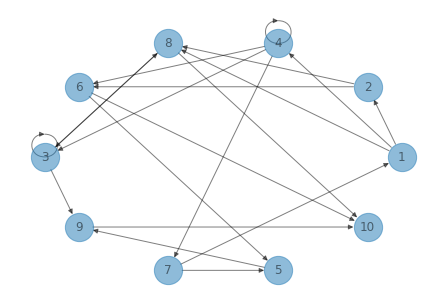

In [144]:
nx.draw(G,pos=nx.circular_layout(G),with_labels=True,node_size=800,alpha=0.5)

In [145]:
nx.shortest_path(G,source=1,target=10)

[1, 8, 10]

# MIP

In [148]:
# create LP
prob = pulp.LpProblem("AllPaths", pulp.LpMinimize)

# x[(i,j)] = 1 if (i,j) is used
x = pulp.LpVariable.dicts("x",
                          G.edges(),
                          cat=pulp.LpBinary)

# objective function : minimize number of edges
prob += pulp.lpSum(x)

# flow conservation
for v in G.nodes():
    if v not in [1,10]:
        inflow = pulp.lpSum(x[(u,v)] for u in G.predecessors(v)) if G.predecessors(v) else 1
        outflow = pulp.lpSum(x[(v,u)] for u in G.successors(v)) if G.successors(v) else 1
        prob += inflow == outflow
prob += 1 == pulp.lpSum(x[(1,u)] for u in G.successors(1))
prob += pulp.lpSum(x[(u,10)] for u in G.predecessors(10)) == 1

# max arcs
prob += pulp.lpSum(x) <= 4

In [149]:
# solve and add no good cuts
k=1
while True:
    # solve MIP
    prob.solve()
    
    # if optimal solution is found, print the edges of the path
    if pulp.LpStatus[prob.status] == "Optimal":
        print()
        print("path",k)
        P = nx.DiGraph()
        for (u, v) in G.edges():
            if pulp.value(x[(u, v)]) > 0.9:
                print(u,v)
                P.add_edge(u,v)
        
        # add no good cut
        yes_vars = pulp.lpSum((1-x[(u, v)]) for (u, v) in P.edges())
        no_vars = pulp.lpSum(x[(u, v)] for (u, v) in G.edges() if (u, v) not in P.edges() and (u in P.nodes() or v in P.nodes())) 
        prob +=  yes_vars + no_vars >= 1
        k+= 1
    else:
        break


path 1
1 8
8 10

path 2
1 2
2 6
6 10

path 3
1 4
4 6
6 10

path 4
1 2
2 8
8 10

path 5
1 8
8 3
8 10
3 8

path 6
1 4
4 3
8 10
3 8

path 7
1 8
8 3
3 9
9 10

path 8
1 4
4 3
3 9
9 10

path 9
1 4
4 4
4 6
6 10
